In [1]:
# Initialization code that runs before all other cells
from preprocessing import preprocess, get_labels, get_features
from extraction import feature_extraction
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise as pw
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
import marimo as mo
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/plant_health_data.csv")
df.head()

,Timestamp,Plant_ID,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal,Plant_Health_Status
0,2024-10-03 10:54:53.407995,1,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402,High Stress
1,2024-10-03 16:54:53.407995,1,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899,High Stress
2,2024-10-03 22:54:53.407995,1,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728,High Stress
3,2024-10-04 04:54:53.407995,1,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088,High Stress
4,2024-10-04 10:54:53.407995,1,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805,High Stress


In [3]:
processed = get_features(df)
X = processed
X.head()

,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal
Timestamp,,,,,,,,,,,
2024-10-03 10:54:53.407995,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402
2024-10-03 16:54:53.407995,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899
2024-10-03 22:54:53.407995,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728
2024-10-04 04:54:53.407995,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088
2024-10-04 10:54:53.407995,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805


# Density Estimation for Outlier Detection
By using Kernel Density estimation we will discover outliers in our dataset. We don't preprocess our dataset 
to save as much variation as possible.  

In [4]:
bandwidth = 0.8
kde = make_pipeline(
    PCA(n_components=3),
    KernelDensity(kernel='cosine',bandwidth=bandwidth)
)
kde.fit(X)

,steps,"[('pca', ...), ('kerneldensity', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


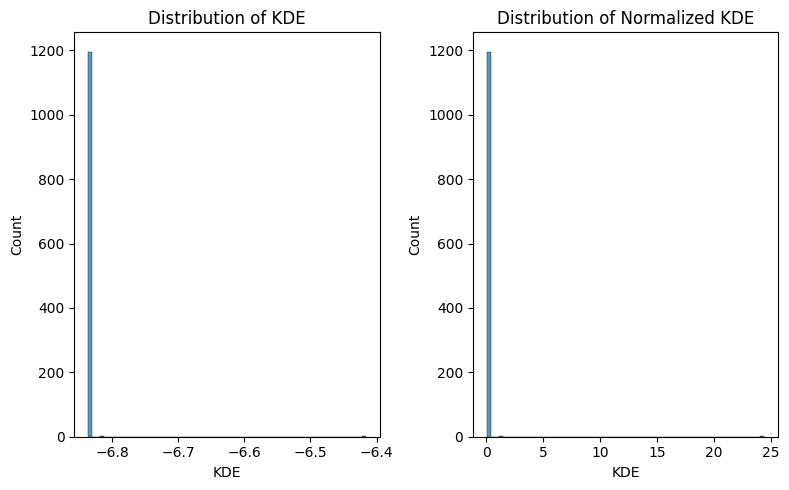

In [6]:
scores = kde.score_samples(X)
plt.figure(figsize = (8,5))
plt.subplot(121)
sns.histplot(scores)
plt.title("Distribution of KDE")
plt.xlabel("KDE")
plt.subplot(122)
z = abs((scores - scores.mean()) / scores.std())
sns.histplot(abs(z))
plt.title("Distribution of Normalized KDE")
plt.xlabel("KDE")
plt.tight_layout()

We see very few outliers in our dataset.  However there are a couple, above we show distributions of KDE scores.  Since KDE assigns
density scores to each sample it essentially acts a function mapping from R^N->R.  To binarize our outliers we use a common technique 
of fitting the function outputs to a normal distribution with a threshold of 0.3

In [7]:
scores_df = pd.DataFrame(data=np.column_stack([scores,z]),columns=['Score','Standardized'])
scores_df.head()

,Score,Standardized
0,-6.836355,0.042793
1,-6.836355,0.042793
2,-6.836355,0.042793
3,-6.836355,0.042793
4,-6.836355,0.042793


In [8]:
mo.md(f"We have {(scores_df['Standardized'] > 3).sum()} outliers in our dataset.  Below we plot where they are in relation to other samples")

_md()

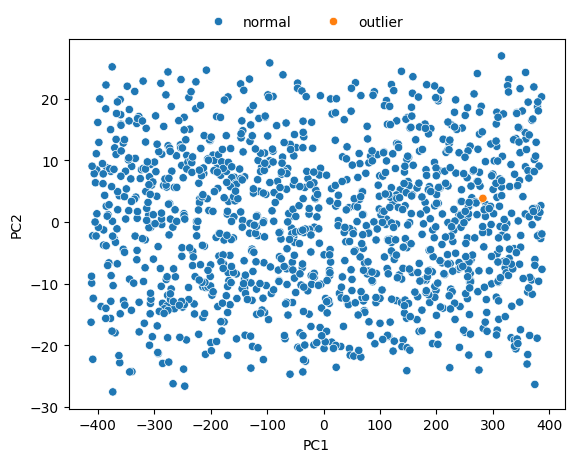

In [9]:
pca = PCA(n_components = 2)
in_2d = pd.DataFrame(
    data=pca.fit_transform(X),
    columns=['PC1','PC2'],
)
in_2d['outliers'] = np.where(scores_df['Standardized'] > 3, 'outlier', 'normal')
sns.scatterplot(in_2d, x = 'PC1', y = 'PC2', hue = 'outliers')
plt.legend(bbox_to_anchor = (0.7,1.1),ncols = 2, frameon = False)

From visualizing the outliers using a 2D PCA projected scatterplot we notice that this outlier truly is a point outlier our a small collective outlier.  If it was a larger set of outliers then they would have effected the PCA projection.  They do not since their distance is obviously not along the 2 bases containing the most variation. That point outlier was likely caused by a temporary failure in sensor reading.